# YOUTUBE API PROJECT

In [130]:
import os
import dotenv
import isodate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
import pandas as pd
import seaborn as sns

from dateutil import parser
from googleapiclient.discovery import build
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [131]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/robert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/robert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [132]:
dotenv.load_dotenv(".env")

True

In [133]:
api_key = os.environ.get("API_KEY")

# Data Pull

In [134]:
channel_ids = [
    "UC8uYStXS2ElBFLZVfuYzIxg"
]

In [135]:
api_service_name = "youtube"
api_version = "v3"

youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [136]:
def get_channel_stats(youtube, channel_ids):

    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    for item in response["items"]:
        data = {
            "channelName": item["snippet"]["title"],
            "subscribers": item["statistics"]["subscriberCount"],
            "views": item["statistics"]["viewCount"],
            "totatViews": item["statistics"]["videoCount"],
            "playlistId": item["contentDetails"]["relatedPlaylists"]["uploads"]
        }
        all_data.append(data)
    return(pd.DataFrame(all_data))

In [137]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [138]:
channel_stats

,channelName,subscribers,views,totatViews,playlistId
0,Przez Świat Na Fazie,539000,104592562,230,UU8uYStXS2ElBFLZVfuYzIxg


In [139]:
playlist_id = "UU8uYStXS2ElBFLZVfuYzIxg"

In [140]:
def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()

    for item in response["items"]:
        video_ids.append(item["contentDetails"]["videoId"])

    next_page_token = response.get("nextPageToken")

    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken = next_page_token
        )
        response = request.execute()

        for item in response["items"]:
            video_ids.append(item["contentDetails"]["videoId"])

        next_page_token = response.get("nextPageToken")

    return video_ids

In [141]:
video_ids = get_video_ids(youtube, playlist_id)

In [142]:
len(video_ids)

232

In [143]:
def get_video_details(youtube, video_ids):
    
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response["items"]:
            stats = {"snippet": ["channelTitle", "title", "description", "tags", "publishedAt"],
                     "statistics": ["viewCount", "likeCount", "commentCount"],
                     "contentDetails": ["duration", "definition", "caption"]
                    }
            video_info = {}
            video_info["video_id"] = video["id"]

            for key in stats.keys():
                for value in stats[key]:
                    try:
                        video_info[value] = video[key][value]
                    except:
                        video_info[value] = None

            all_video_info.append(video_info)
        
    return pd.DataFrame(all_video_info)

In [144]:
video_df = get_video_details(youtube, video_ids)

In [145]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,e8EeMoFA5x0,Przez Świat Na Fazie,#167 Przez Świat na Fazie - Wypadek | UZBEKIST...,Witam Was Fazowicze i Fazowiczki! Przed Wami o...,"[przezswiatnafazie, przez, świat, uzbekistan, ...",2023-06-18T09:57:13Z,104750,6241,984,PT18M52S,hd,false
1,wDQ7h8DU44M,Przez Świat Na Fazie,#166 Przez Świat na Fazie - Misja specjalna | ...,Fazowicze i Fazowiczki! Przed Wami kolejny odc...,"[przezswiatnafazie, patec, patecki, patecwaria...",2023-06-11T09:57:44Z,191459,6497,484,PT25M5S,hd,false
2,0nSR4DXhL-g,Przez Świat Na Fazie,#165 Przez Świat na Fazie - Awantura w autobus...,Fazowicze i Fazowiczki! Przed Wami kolejny odc...,"[przezswiatnafazie, patecki, patecwariatec, fa...",2023-06-04T08:58:58Z,207455,7085,565,PT24M6S,hd,false
3,DZ6W6flhUfg,Przez Świat Na Fazie,#164 Przez Świat na Fazie - Przygodę czas zacz...,Witam Was serdecznie Fazowicze i Fazowiczki. P...,"[przezswiatnafazie, na fazie, przez, izrael, p...",2023-05-28T09:58:59Z,191908,8506,465,PT21M47S,hd,false
4,ViwsE2S0-E4,Przez Świat Na Fazie,#163 Przez Świat na Fazie - Ostry poślizg | IZ...,Fazowicze i Fazowiczki! Zapraszam Was na ostat...,"[przezswiatnafazie, na fazie, przez, izrael, p...",2023-05-21T09:57:43Z,163891,6620,575,PT22M59S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
227,NEKVy_34HVs,Przez Świat Na Fazie,5# Przez Świat na Fazie - Jachtostop,,"[przez świat na fazie, fazowski, na fazie prze...",2014-11-02T15:16:57Z,309591,3472,94,PT5M32S,hd,false
228,p79FR9uA0uA,Przez Świat Na Fazie,#2 Przez Świat na Fazie - Hiszpania,,"[przez świat na fazie, fazowski, na fazie prze...",2014-10-23T12:33:14Z,520508,5563,189,PT6M44S,hd,false
229,bLoWNzsbYug,Przez Świat Na Fazie,#4 Przez Świat na Fazie - No to płyniemy po oc...,,"[przez świat na fazie, fazowski, na fazie prze...",2014-10-10T19:57:59Z,425180,4259,94,PT3M34S,hd,false
230,OMjmmD9WF8Q,Przez Świat Na Fazie,#3 Przez Świat na Fazie - Giblartar,,"[przez świat na fazie, fazowski, na fazie prze...",2014-09-30T11:39:49Z,321621,2980,67,PT1M57S,hd,false


## Data Pre-processing

In [146]:
video_df.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
tags            False
publishedAt     False
viewCount       False
likeCount       False
commentCount    False
duration        False
definition      False
caption         False
dtype: bool

In [149]:
video_df.dtypes

video_id        object
channelTitle    object
title           object
description     object
tags            object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
caption         object
dtype: object

In [150]:
numeric_cols = ["viewCount", "likeCount", "commentCount"]
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = "coerce", axis = 1)

In [151]:
video_df["publishedAt"] = video_df["publishedAt"].apply(lambda x: parser.parse(x))

In [152]:
video_df["publishDay"] = video_df["publishedAt"].apply(lambda x: x.strftime("%A"))

In [153]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,publishDay
0,e8EeMoFA5x0,Przez Świat Na Fazie,#167 Przez Świat na Fazie - Wypadek | UZBEKIST...,Witam Was Fazowicze i Fazowiczki! Przed Wami o...,"[przezswiatnafazie, przez, świat, uzbekistan, ...",2023-06-18 09:57:13+00:00,104750,6241,984,PT18M52S,hd,false,Sunday
1,wDQ7h8DU44M,Przez Świat Na Fazie,#166 Przez Świat na Fazie - Misja specjalna | ...,Fazowicze i Fazowiczki! Przed Wami kolejny odc...,"[przezswiatnafazie, patec, patecki, patecwaria...",2023-06-11 09:57:44+00:00,191459,6497,484,PT25M5S,hd,false,Sunday
2,0nSR4DXhL-g,Przez Świat Na Fazie,#165 Przez Świat na Fazie - Awantura w autobus...,Fazowicze i Fazowiczki! Przed Wami kolejny odc...,"[przezswiatnafazie, patecki, patecwariatec, fa...",2023-06-04 08:58:58+00:00,207455,7085,565,PT24M6S,hd,false,Sunday
3,DZ6W6flhUfg,Przez Świat Na Fazie,#164 Przez Świat na Fazie - Przygodę czas zacz...,Witam Was serdecznie Fazowicze i Fazowiczki. P...,"[przezswiatnafazie, na fazie, przez, izrael, p...",2023-05-28 09:58:59+00:00,191908,8506,465,PT21M47S,hd,false,Sunday
4,ViwsE2S0-E4,Przez Świat Na Fazie,#163 Przez Świat na Fazie - Ostry poślizg | IZ...,Fazowicze i Fazowiczki! Zapraszam Was na ostat...,"[przezswiatnafazie, na fazie, przez, izrael, p...",2023-05-21 09:57:43+00:00,163891,6620,575,PT22M59S,hd,false,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,NEKVy_34HVs,Przez Świat Na Fazie,5# Przez Świat na Fazie - Jachtostop,,"[przez świat na fazie, fazowski, na fazie prze...",2014-11-02 15:16:57+00:00,309591,3472,94,PT5M32S,hd,false,Sunday
228,p79FR9uA0uA,Przez Świat Na Fazie,#2 Przez Świat na Fazie - Hiszpania,,"[przez świat na fazie, fazowski, na fazie prze...",2014-10-23 12:33:14+00:00,520508,5563,189,PT6M44S,hd,false,Thursday
229,bLoWNzsbYug,Przez Świat Na Fazie,#4 Przez Świat na Fazie - No to płyniemy po oc...,,"[przez świat na fazie, fazowski, na fazie prze...",2014-10-10 19:57:59+00:00,425180,4259,94,PT3M34S,hd,false,Friday
230,OMjmmD9WF8Q,Przez Świat Na Fazie,#3 Przez Świat na Fazie - Giblartar,,"[przez świat na fazie, fazowski, na fazie prze...",2014-09-30 11:39:49+00:00,321621,2980,67,PT1M57S,hd,false,Tuesday


In [154]:
video_df['durationSec'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))

In [155]:
video_df['durationSec'] = video_df['durationSec'].astype('timedelta64[s]')

In [156]:
video_df[["durationSec", "duration"]]

,durationSec,duration
0,0 days 00:18:52,PT18M52S
1,0 days 00:25:05,PT25M5S
2,0 days 00:24:06,PT24M6S
3,0 days 00:21:47,PT21M47S
4,0 days 00:22:59,PT22M59S
...,...,...
227,0 days 00:05:32,PT5M32S
228,0 days 00:06:44,PT6M44S
229,0 days 00:03:34,PT3M34S
230,0 days 00:01:57,PT1M57S


In [157]:
video_df["tagCount"] = video_df["tags"].apply(lambda x: 0 if x is None else len(x))

In [158]:
video_df["tagCount"]

0      33
1      33
2      32
3      31
4      31
       ..
227     9
228     9
229     9
230     9
231     9
Name: tagCount, Length: 232, dtype: int64

# Most watched videos

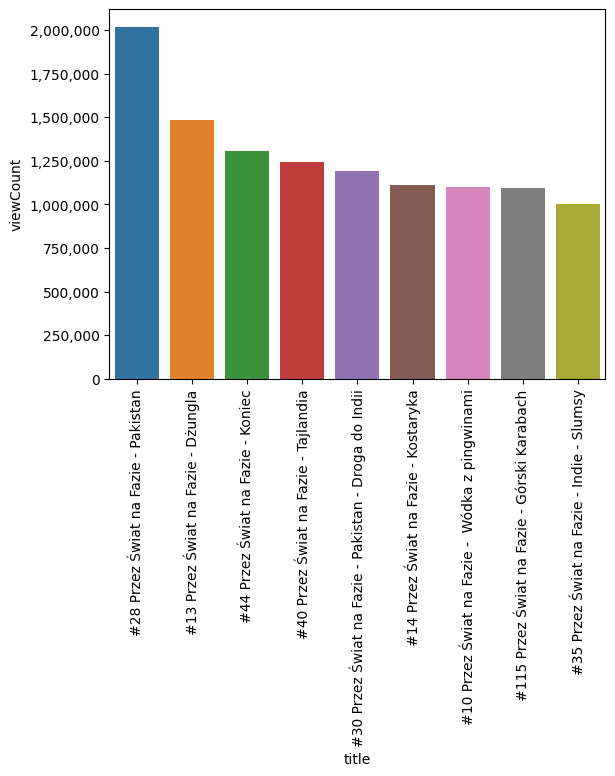

In [159]:
ax = sns.barplot(x = "title", y = "viewCount", data = video_df.sort_values("viewCount", ascending=False)[0:9])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Least watched videos

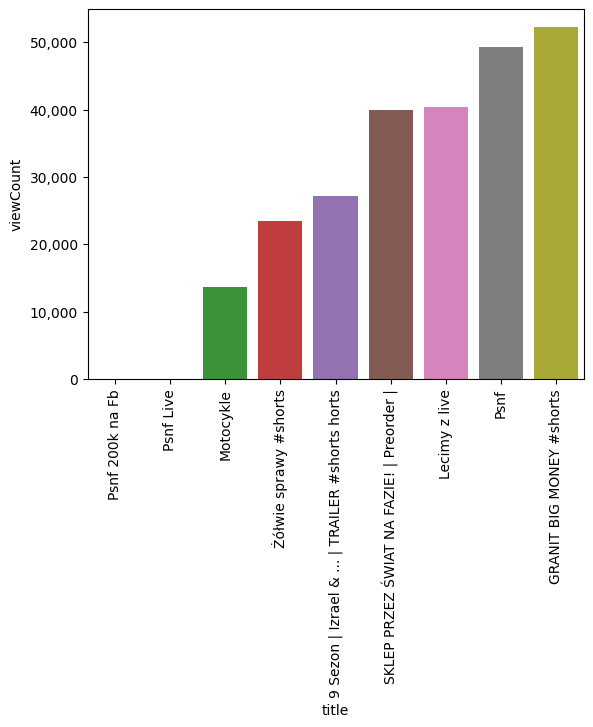

In [161]:
ax = sns.barplot(x = "title", y = "viewCount", data = video_df.sort_values("viewCount", ascending=True)[0:9])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# View distribution

<Axes: >

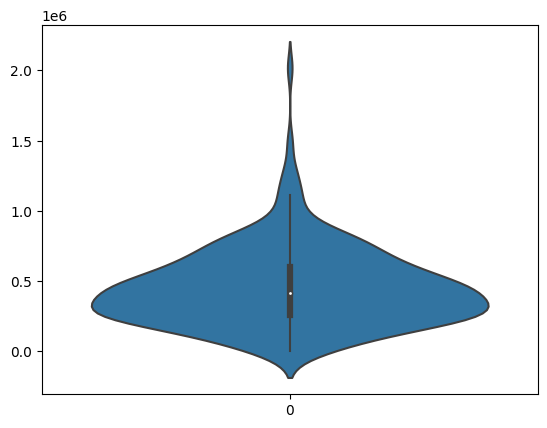

In [162]:
sns.violinplot(video_df["viewCount"])

<Axes: xlabel='likeCount', ylabel='viewCount'>

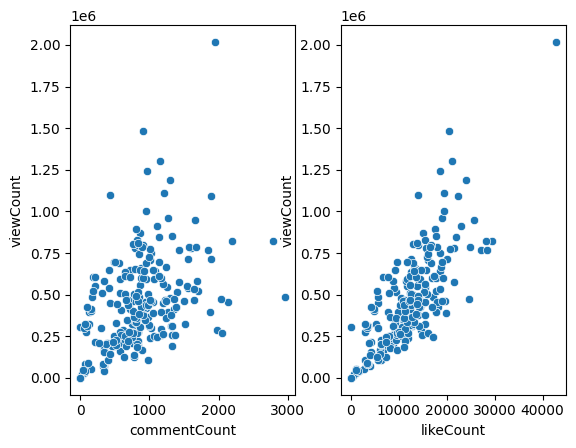

In [163]:
fix, ax = plt.subplots(1, 2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax = ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax = ax[1])

<Axes: xlabel='durationSec', ylabel='Count'>

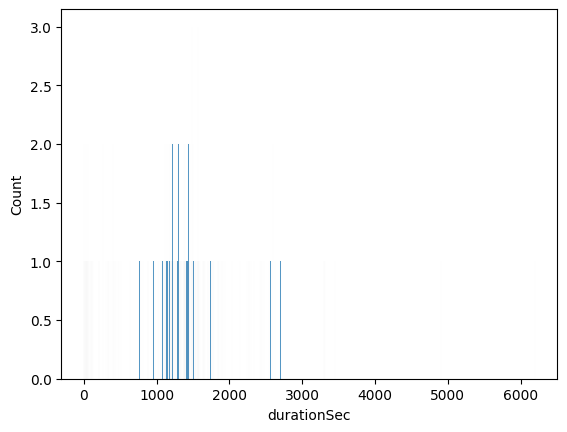

In [164]:
sns.histplot(data = video_df, x = "durationSec", bins=30)

## Wordcloud

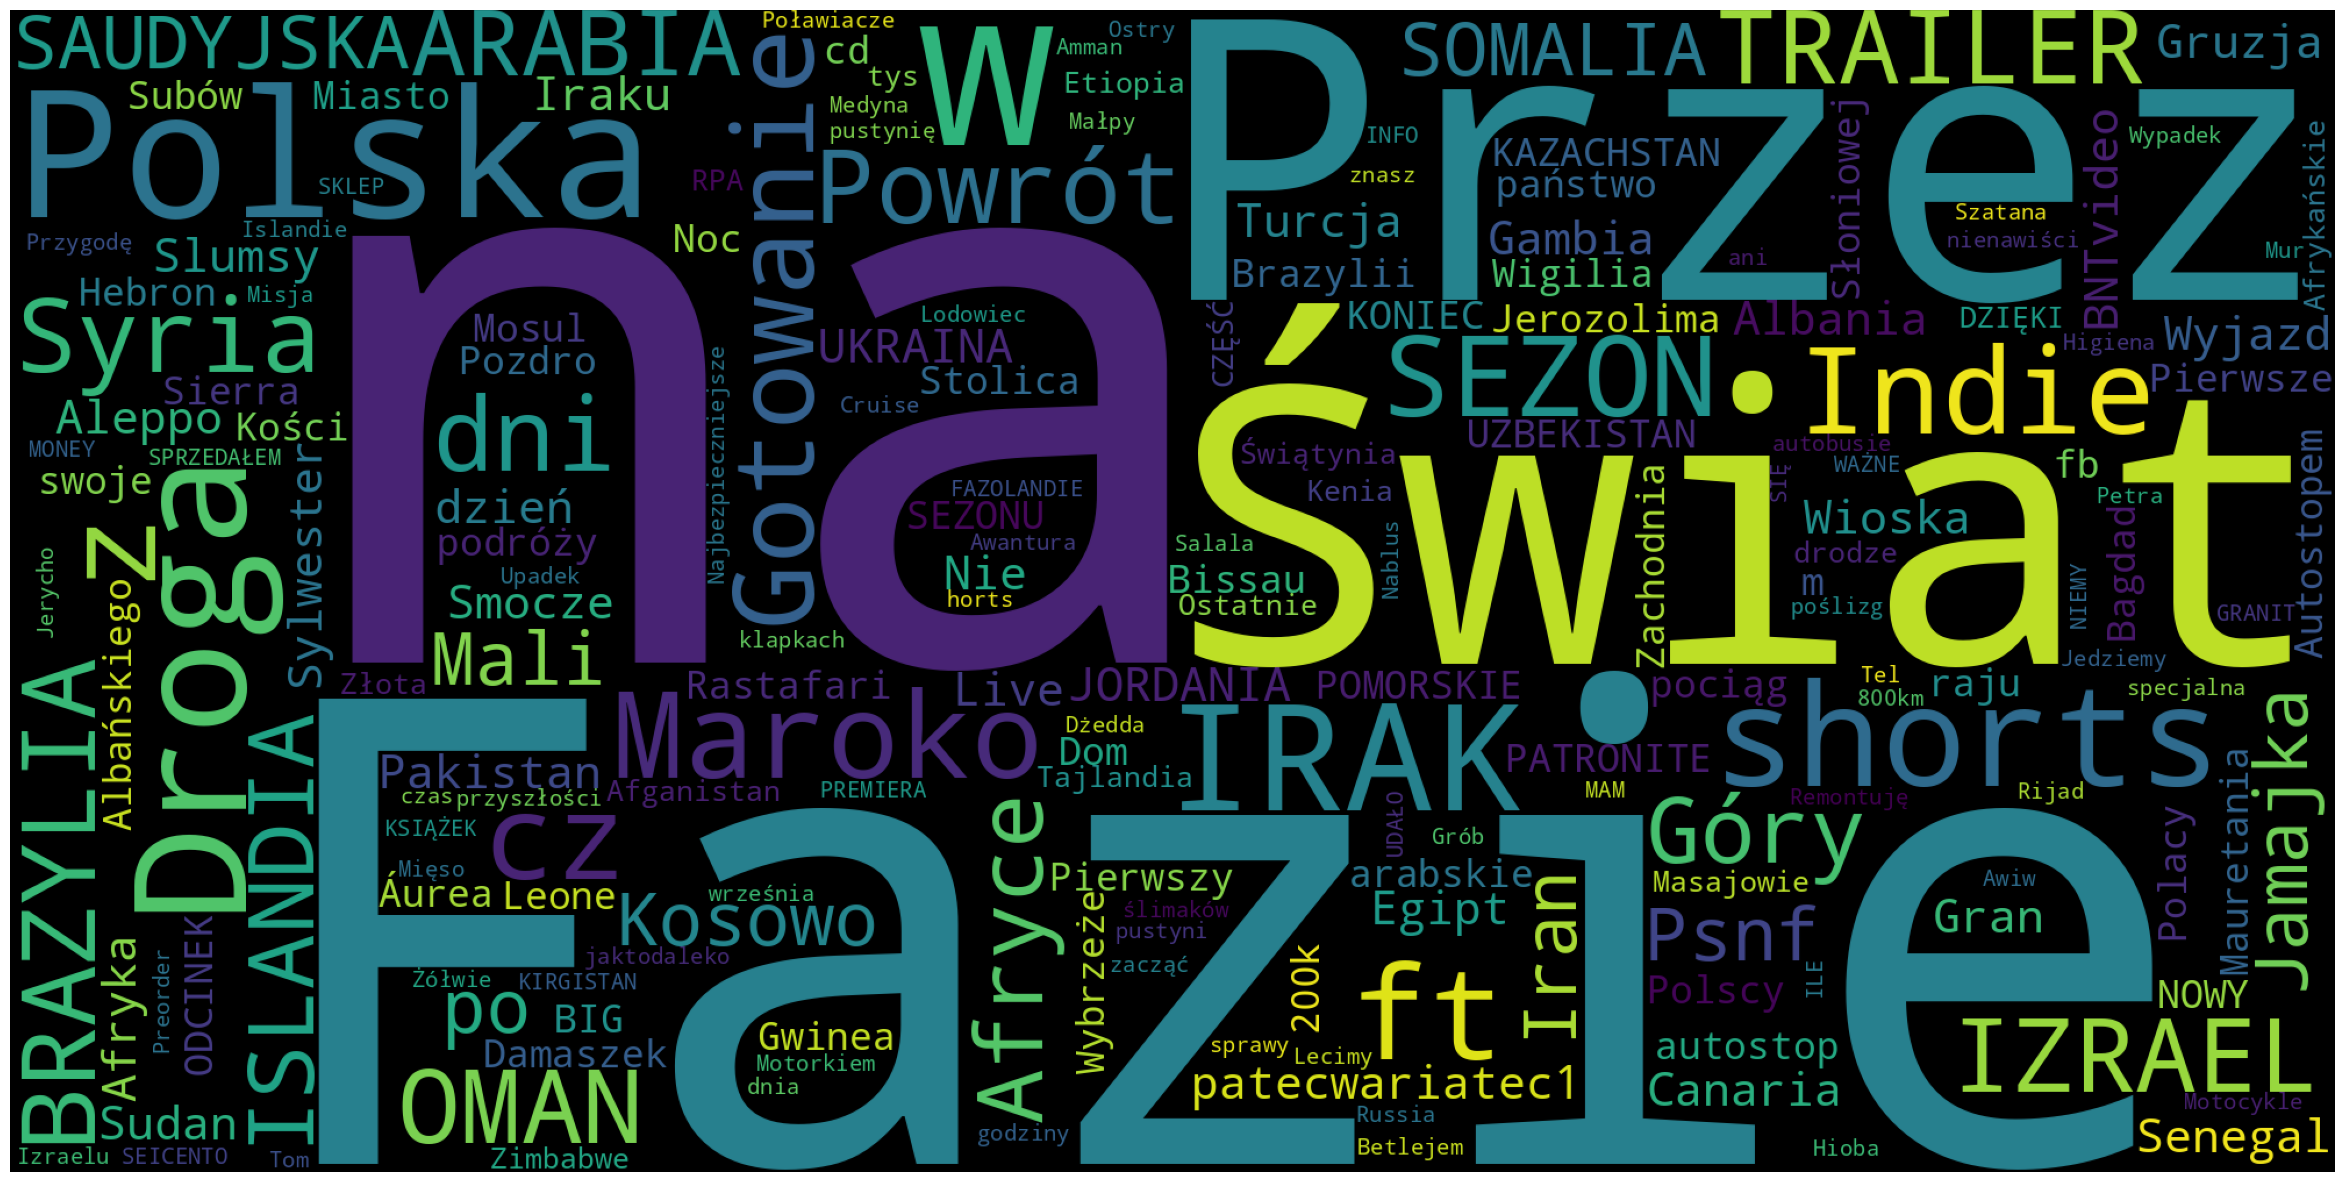

In [180]:
video_df['title_words'] = video_df['title'].apply(lambda x: [item for item in str(x).split()])

all_words = list([a for b in video_df['title_words'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)